In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  7 10:00:55 2017

@author: NPBME
"""

import h5py
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense


                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'


# Retrieve data  --------------------------------------------------------------
#
#
#

seed = 7
np.random.seed(seed)

f                   = h5py.File('/content/drive/My Drive/ISS/ISY5002 Pattern Recognition Systems/2. Pattern Recognition and Machine Learning Systems/Day 3/workshop/cad5sec.mat')
X                   = f["data"]
Y                   = f["classLabel"]
data                = np.array(X)
data                = np.transpose(data)
label               = np.array(Y)
label               = np.transpose(label)


nor                 = data[0:32000]
cad                 = data[32000:38120]



# stepzation function ---------------------------------------------------------
#
#
# This function creates segmenets of a 1D signal
# It works in batch
#
#
# Dependency:       numpy

def makeSteps(dat, length, dist):
    width           = dat.shape[1]
    numOfSteps      = int(np.floor((width-length)/dist)+1)

                                        # Initialize the output
    segments        = np.zeros([dat.shape[0],numOfSteps,length],
                               dtype=dat.dtype)

    for l in range(numOfSteps):
        segments[:,l,:]     = dat[:,(l*dist):(l*dist+length)]

    return segments





# Splitting data into training and testing set---------------------------------
#
#
#


print('Create dataset...')
trNor               = nor[0:28800].copy()
tsNor               = nor[28800:32000].copy()
trCad               = cad[0:5000].copy()
tsCad               = cad[5000:6120].copy()




# Create segments from the signals --------------------------------------------
#
#
#

length              = 24
dist                = 6

print('Finalizing all the data ....')
trNorS              = makeSteps(trNor, length, dist)
tsNorS              = makeSteps(tsNor, length, dist)
trCadS              = makeSteps(trCad, length, dist)
tsCadS              = makeSteps(tsCad, length, dist)

trDat               = np.vstack([trNorS,trCadS])
tsDat               = np.vstack([tsNorS,tsCadS])

trLbl               = np.vstack([np.zeros([trNorS.shape[0],1]),
                                 np.ones([trCadS.shape[0],1])])
tsLbl               = np.vstack([np.zeros([tsNorS.shape[0],1]),
                                 np.ones([tsCadS.shape[0],1])])

Create dataset...
Finalizing all the data ....


In [3]:
# Creating model --------------------------------------------------------------
#
#
#


print('Creating lstm model...')

modelname   = 'wks3_2_2'

def createModel():
    inputs = Input(shape=(trDat.shape[1],length))
    y = Conv1D(32, 5, activation='relu')(inputs)
    y = Dropout(0.25)(y)
    y = Conv1D(32, 5, activation='relu')(y)
    y = MaxPooling1D(2)(y)
    y = Conv1D(48, 5, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Conv1D(48, 5, activation='relu')(y)
    y = MaxPooling1D(2)(y)
    y = Conv1D(64, 5, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Conv1D(64, 5, activation='relu')(y)
    y = MaxPooling1D(2)(y)
    y = LSTM(8,
    return_sequences=True,
    dropout=0.5,
    recurrent_dropout=0.5)(y)
    y = LSTM(4,
    return_sequences=True,
    dropout=0.5,
    recurrent_dropout=0.5)(y)
    y = LSTM(2)(y)
    y = Dense(1, activation='sigmoid')(y)
    model = Model(inputs=inputs,outputs=y)
    model.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
    return model
                            # Setup the models
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()



W0826 13:46:14.824079 140464611313536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Creating lstm model...


W0826 13:46:16.244829 140464611313536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 211, 24)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 207, 32)           3872      
_________________________________________________________________
dropout (Dropout)            (None, 207, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 203, 32)           5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 101, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 48)            7728      
_________________________________________________________________
dropout_1 (Dropout)          (None, 97, 48)            0     

Train on 33800 samples, validate on 4320 samples
Epoch 1/30
33800/33800 [==============================] - 26s 767us/sample - loss: 0.0245 - acc: 0.9939 - val_loss: 0.5587 - val_acc: 0.8713
Epoch 2/30
33800/33800 [==============================] - 26s 767us/sample - loss: 0.0210 - acc: 0.9948 - val_loss: 0.5292 - val_acc: 0.8824
Epoch 3/30
33800/33800 [==============================] - 26s 767us/sample - loss: 0.0240 - acc: 0.9938 - val_loss: 0.5474 - val_acc: 0.8843
Epoch 4/30
33800/33800 [==============================] - 26s 765us/sample - loss: 0.0222 - acc: 0.9943 - val_loss: 0.5485 - val_acc: 0.8759
Epoch 5/30
33800/33800 [==============================] - 26s 771us/sample - loss: 0.0220 - acc: 0.9940 - val_loss: 0.5483 - val_acc: 0.8910
Epoch 6/30
33800/33800 [==============================] - 26s 770us/sample - loss: 0.0202 - acc: 0.9947 - val_loss: 0.5761 - val_acc: 0.8815
Epoch 7/30
33800/33800 [==============================] - 26s 770us/sample - loss: 0.0171 - acc: 0.9955 -

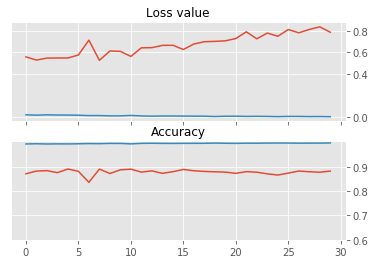

In [5]:
# .............................................................................


                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath,
                                  monitor='val_acc',
                                  verbose=0,
                                  save_best_only=True,
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]



# .............................................................................


                            # Fit the model
                            # This is where the training starts
model.fit(trDat,
          trLbl,
          validation_data=(tsDat, tsLbl),
          epochs=30,
          batch_size=256,
          shuffle=True,
          callbacks=callbacks_list)



# ......................................................................


                            # Now the training is complete, we get
                            # another object to load the weights
                            # compile it, so that we can do
                            # final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])





# .......................................................................


                            # Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

labelname   = ['Normal','CAD']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(tsLbl,predicts.round())
confusion   = metrics.confusion_matrix(tsLbl,predicts.round())


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(tsLbl,predicts.round(),target_names=labelname,digits=4))
print(confusion)





# ..................................................................

import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()

In [0]:
# ................................................................

from tensorflow.keras.utils import plot_model

plot_model(model,
           to_file=modelname+'_model.pdf',
        #    to_file='model.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB')